In [1]:
import torch
from torch.autograd import Variable

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [2]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]), requires_grad=True)
print x_i

### Step 1: compute V(x)
P_size = 12
P = Variable(torch.ones(P_size), requires_grad=True)

def compute_V(x):
    V_monomials = Variable(torch.zeros(P_size))
    V_monomials[0] = x[0]**2
    V_monomials[1] = x[0]**4
    V_monomials[2] = x[1]**2
    V_monomials[3] = x[1]**4
    V_monomials[4] = torch.cos(x[0]).pow(2)
    V_monomials[5] = torch.sin(x[0]).pow(2)
    # mixed terms
    V_monomials[6] = (x[0]*x[1]).pow(2)
    V_monomials[7] = (x[0]*torch.cos(x[0])).pow(2)
    V_monomials[8] = (x[0]*torch.sin(x[0])).pow(2)
    V_monomials[9] = (torch.sin(x[0])*torch.cos(x[0])).pow(2)
    V_monomials[10] = (x[1]*torch.cos(x[0])).pow(2)
    V_monomials[11] = (x[1]*torch.sin(x[0])).pow(2)
    v = torch.dot(torch.abs(P), V_monomials)
    v = v*torch.abs(torch.sin(x[0]))
    return v

### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K_size = 16
K = torch.ones(K_size)
K[3] = 0.0
K[5] = 0.0
K[14] = 0.0
K = Variable(K, requires_grad=True)
print K

## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg
b = 10.0    # damping

def policy(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[0]
    monomials[1] = x[0]**2
    monomials[2] = x[0]**3
    monomials[3] = x[1]
    monomials[4] = x[1]**2
    monomials[5] = x[1]**3
    monomials[6] = torch.cos(x[0])
    monomials[7] = torch.cos(x[0]).pow(2)
    monomials[8] = torch.sin(x[0])
    monomials[9] = torch.sin(x[0]).pow(2)
    # mixed terms
    monomials[10] = x[0]*x[1]
    monomials[11] = x[0]*torch.cos(x[0])
    monomials[12] = x[0]*torch.sin(x[0])
    monomials[13] = torch.sin(x[0])*torch.cos(x[0])
    monomials[14] = x[1]*torch.cos(x[0])
    monomials[15] = x[1]*torch.sin(x[0])
    u = torch.dot(K, monomials)
    return u
    
### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2))
    xdot[0] = x[1]
    u = policy(x)
    xdot[1] = -(m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot

xdot = dynamics(x_i)
print xdot

### Step 5: compute Vdot

def compute_Vdot(x):
    V = compute_V(x)
    V.backward(torch.FloatTensor([1.0]),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot
    
Vdot = compute_Vdot(x_i)
print Vdot
Vdot.backward()

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
 1
 0
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
[torch.FloatTensor of size 16]

Variable containing:
   1.1000
-247.9386
[torch.FloatTensor of size 2]

Variable containing:
-2472.9197
[torch.FloatTensor of size 1]



## Let's test that V is psd

In [3]:
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    V = compute_V(x_i)
    if V.data[0] < 0:
        raise ValueError("false, counterexample found: " + str(x_i))
        break

print "no counterexamples found!"

no counterexamples found!


## Let's test that Vdot isn't yet psd

In [4]:
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: " + str(x_i)
        break

false, counterexample found: Variable containing:
-0.5747
 0.8218
[torch.FloatTensor of size 2]



## Now let's search for K, from an initialization not stable

<IPython.core.display.Javascript object>


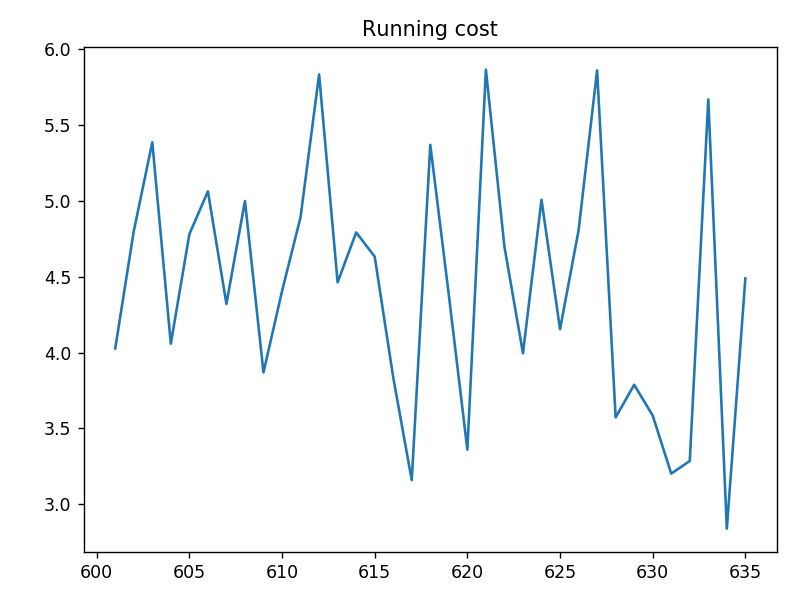

In [5]:
## optimization plotting tool
%matplotlib notebook
import matplotlib.pyplot as plt 

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [ ]:
## optimize

num_iterations = 1000
step_rate = 1e-4

# K has already been initialized above, and initial policy visualized

for cost_iteration in range(num_iterations):
    
    cost = 0
    
    for i in range(100):
        x_i = Variable(torch.randn(2), requires_grad=True)
        Vdot = compute_Vdot(x_i)
        cost += Vdot.clamp(min=0)
        
    ## Automatically differentiate
    cost.backward()

    # Update P and K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
      
    # Kill any elements that are tiny
    for idx, val in enumerate(K):
        if val.data[0] < 1e-4:
            K.data[idx] = 0.0
    for idx, val in enumerate(P):
        if val.data[0] < 1e-4:
            P.data[idx] = 0.0
        
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 5 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        print "K is", K
        print "P is", P
        print "cost is", cost.data[0]
        
    if cost.data[0] == 0:
        print "certificate found"
        break
        
    if cost_iteration % 100 == 0:
        #reset plots so they autozoom better
        cost_iteration_number_history = []
        cost_history = []
        

K is Variable containing:
 1.0308
 1.0097
 1.0958
 0.0000
 1.0127
 0.0000
 1.0013
 1.0007
 1.0176
 1.0045
 0.9872
 0.9963
 1.0062
 1.0003
 0.0000
 0.9907
[torch.FloatTensor of size 16]

P is Variable containing:
 0.9914
 0.9802
 0.9939
 0.9870
 0.9976
 0.9959
 0.9905
 0.9983
 0.9931
 0.9990
 0.9981
 0.9958
[torch.FloatTensor of size 12]

cost is 49500.7734375
K is Variable containing:
 1.2145
 1.0171
 1.4415
 0.0000
 1.0145
 0.0000
 1.0155
 1.0135
 1.1514
 1.0086
 0.9900
 1.0441
 1.0101
 1.0492
 0.0000
 0.9870
[torch.FloatTensor of size 16]

P is Variable containing:
 0.9518
 0.8722
 0.9634
 0.8962
 0.9860
 0.9782
 0.9523
 0.9886
 0.9632
 0.9946
 0.9860
 0.9774
[torch.FloatTensor of size 12]

cost is 92112.0234375
K is Variable containing:
 1.4105
 0.8581
 1.9386
 0.0000
 0.6318
 0.0000
 1.0075
 0.9893
 1.2783
 0.9675
 1.2081
 1.0579
 0.9337
 1.0804
 0.0000
 1.0991
[torch.FloatTensor of size 16]

P is Variable containing:
 0.9098
 0.7627
 0.9320
 0.8030
 0.9743
 0.9598
 0.9101
 0.9799


K is Variable containing:
 3.0038
 0.7981
 5.3645
 0.0000
 0.8376
 0.0000
 1.0376
 0.9925
 2.3747
 0.9950
 1.0853
 1.3040
 0.9708
 1.3958
 0.0000
 1.0212
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0585
 0.0000
 0.3094
 0.0000
 0.7380
 0.5849
 0.0575
 0.7880
 0.2705
 0.9034
 0.7298
 0.5797
[torch.FloatTensor of size 12]

cost is 8430.55273438
K is Variable containing:
 3.0279
 0.7977
 5.4144
 0.0000
 0.8380
 0.0000
 1.0384
 0.9931
 2.3917
 0.9951
 1.0857
 1.3086
 0.9708
 1.4008
 0.0000
 1.0212
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0158
 0.0000
 0.2832
 0.0000
 0.7270
 0.5670
 0.0202
 0.7784
 0.2374
 0.8994
 0.7200
 0.5632
[torch.FloatTensor of size 12]

cost is 8046.62890625
K is Variable containing:
 3.0481
 0.7985
 5.4465
 0.0000
 0.8305
 0.0000
 1.0374
 0.9927
 2.4071
 0.9945
 1.0872
 1.3158
 0.9704
 1.4075
 0.0000
 1.0231
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.2535
 0.0000
 0.7159
 0.5481
 0.0000
 0.7697


K is Variable containing:
 3.2822
 0.8035
 5.8581
 0.0000
 0.8364
 0.0000
 1.0405
 0.9962
 2.5809
 0.9959
 1.0827
 1.3845
 0.9725
 1.4767
 0.0000
 1.0201
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.4807
 0.1715
 0.0000
 0.5836
 0.0000
 0.8088
 0.4754
 0.1695
[torch.FloatTensor of size 12]

cost is 1921.14294434
K is Variable containing:
 3.2879
 0.8029
 5.8645
 0.0000
 0.8314
 0.0000
 1.0399
 0.9957
 2.5855
 0.9953
 1.0843
 1.3871
 0.9719
 1.4790
 0.0000
 1.0215
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.4692
 0.1535
 0.0000
 0.5749
 0.0000
 0.8045
 0.4619
 0.1486
[torch.FloatTensor of size 12]

cost is 2516.64550781
K is Variable containing:
 3.2944
 0.8032
 5.8756
 0.0000
 0.8306
 0.0000
 1.0402
 0.9957
 2.5905
 0.9960
 1.0842
 1.3893
 0.9725
 1.4814
 0.0000
 1.0211
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.4578
 0.1353
 0.0000
 0.5667


K is Variable containing:
 3.3444
 0.8015
 5.9487
 0.0000
 0.8299
 0.0000
 1.0400
 0.9953
 2.6298
 0.9957
 1.0847
 1.4104
 0.9719
 1.5030
 0.0000
 1.0213
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2246
 0.0000
 0.0000
 0.3802
 0.0000
 0.7155
 0.2264
 0.0000
[torch.FloatTensor of size 12]

cost is 467.980163574
K is Variable containing:
 3.3458
 0.8015
 5.9510
 0.0000
 0.8296
 0.0000
 1.0399
 0.9951
 2.6310
 0.9956
 1.0848
 1.4110
 0.9719
 1.5037
 0.0000
 1.0214
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2131
 0.0000
 0.0000
 0.3685
 0.0000
 0.7112
 0.2147
 0.0000
[torch.FloatTensor of size 12]

cost is 506.666778564
K is Variable containing:
 3.3470
 0.8014
 5.9524
 0.0000
 0.8289
 0.0000
 1.0396
 0.9949
 2.6320
 0.9956
 1.0850
 1.4117
 0.9718
 1.5044
 0.0000
 1.0216
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2020
 0.0000
 0.0000
 0.3603


K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.1726
 0.0000
 0.6207
 0.0000
 0.0000
[torch.FloatTensor of size 12]

cost is 11.0123138428
K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.1642
 0.0000
 0.6163
 0.0000
 0.0000
[torch.FloatTensor of size 12]

cost is 6.60901832581
K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.1556


K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.5252
 0.0000
 0.0000
[torch.FloatTensor of size 12]

cost is 4.68153619766
K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.5209
 0.0000
 0.0000
[torch.FloatTensor of size 12]

cost is 2.94068646431
K is Variable containing:
 3.3583
 0.8011
 5.9674
 0.0000
 0.8267
 0.0000
 1.0392
 0.9945
 2.6411
 0.9954
 1.0853
 1.4171
 0.9716
 1.5099
 0.0000
 1.0221
[torch.FloatTensor of size 16]

P is Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000


In [11]:
print P, K

Variable containing:
-0.0872
-0.3069
 0.0490
 0.3889
-0.0918
-0.1973
-0.1314
 0.0117
 0.4191
-0.0040
 0.0348
 0.0277
[torch.FloatTensor of size 12]
 Variable containing:
 67.5595
 -1.1316
 13.0617
-65.9846
  2.4485
-84.0961
  1.2618
  0.5706
 60.8520
  1.2450
 -0.2378
 40.5086
  0.9908
 24.6711
-15.5537
  0.2856
[torch.FloatTensor of size 16]



In [12]:
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    V = compute_V(x_i)
    if V.data[0] < 0:
        raise ValueError("false, counterexample found: " + str(x_i))
        break

print "no counterexamples found!"

no counterexamples found!


In [16]:
K = Variable(torch.ones(K_size), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: " + str(x_i)
        print i
        break

false, counterexample found: Variable containing:
-0.1488
 0.8370
[torch.FloatTensor of size 2]

0


In [ ]:
# print P, K
# Variable containing:
# -0.0054
#  0.0013
# -0.0008
#  0.0091
# -0.0019
# -0.0031
#  0.0001
#  0.0007
# -0.0047
#  0.1880
#  0.0001
# -0.0001
# [torch.FloatTensor of size 12]
#  Variable containing:
#  3.4842
#  1.0922
#  6.3908
# -2.0840
#  0.8997
# -9.6159
#  0.9726
#  0.9978
#  2.7145
#  1.0054
#  0.9635
#  1.4121
#  1.0323
#  1.5092
# -0.1681
#  1.0216
# [torch.FloatTensor of size 16]